# **Bachelor Project    Pouria Zarrehparvar **

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf
import warnings
import tensorflow_hub as hub

warnings.filterwarnings('ignore')


In [ ]:
# Read Data

In [ ]:


drive.mount('/content/drive')

path = "/content/drive/MyDrive/True.csv"
df_RealData = pd.read_csv(path)

path = "/content/drive/MyDrive/Fake.csv"
df_FakeData = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_RealData.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_FakeData.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_RealData['label'] = 1
df_FakeData['label'] = 0

In [ ]:
df_RealData.tail()
df_FakeData.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
df = pd.concat([df_RealData,df_FakeData], ignore_index=True, sort=False)

In [ ]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df['date'] = df['date'].replace(['19-Feb-18'],'February 19, 2018')
df['date'] = df['date'].replace(['18-Feb-18'],'February 18, 2018')
df['date'] = df['date'].replace(['17-Feb-18'],'February 17, 2018')
df['date'] = df['date'].replace(['16-Feb-18'],'February 16, 2018')
df['date'] = df['date'].replace(['15-Feb-18'],'February 15, 2018')
df['date'] = df['date'].replace(['14-Feb-18'],'February 14, 2018')
df['date'] = df['date'].replace(['13-Feb-18'],'February 13, 2018')


df['date'] = df['date'].str.replace('Dec ', 'December ')
df['date'] = df['date'].str.replace('Nov ', 'November ')
df['date'] = df['date'].str.replace('Oct ', 'October ')
df['date'] = df['date'].str.replace('Sep ', 'September ')
df['date'] = df['date'].str.replace('Aug ', 'August ')
df['date'] = df['date'].str.replace('Jul ', 'July ')
df['date'] = df['date'].str.replace('Jun ', 'June ')
df['date'] = df['date'].str.replace('Apr ', 'April ')
df['date'] = df['date'].str.replace('Mar ', 'March ')
df['date'] = df['date'].str.replace('Feb ', 'February ')
df['date'] = df['date'].str.replace('Jan ', 'January ')

In [ ]:
df['date'] = df['date'].str.replace(' ', '')
for i, val in enumerate(df['date']):
    df['date'].iloc[i] = pd.to_datetime(df['date'].iloc[i], format='%B%d,%Y', errors='coerce')

In [ ]:
df['date'] = df['date'].astype('datetime64[ns]')
import datetime as dt
df['year'] = pd.to_datetime(df['date']).dt.to_period('Y')
df['month'] = pd.to_datetime(df['date']).dt.to_period('M')

df['month'] = df['month'].astype(str)

In [ ]:
df.head()

,title,text,subject,date,label,year,month
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017,2017-12
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017,2017-12
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017,2017-12
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017,2017-12
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017,2017-12


In [ ]:
sub = df[['month', 'label']]
sub = sub.dropna()
sub = sub.groupby(['month'])['label'].sum()
sub = sub.drop('NaT')

In [ ]:
sub

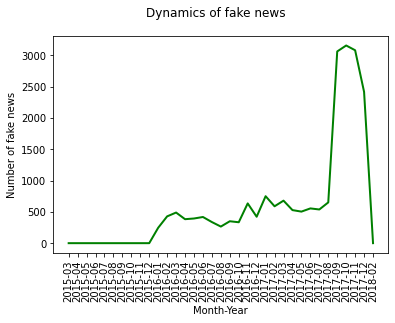

In [ ]:
import matplotlib.pyplot as plt

plt.suptitle('Dynamics of fake news')
plt.xticks(rotation=90)
plt.ylabel('Number of fake news')
plt.xlabel('Month-Year')
plt.plot(sub.index, sub.values, linewidth=2, color='green')

In [ ]:
data = pd.concat([df_RealData,df_FakeData], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
# Visualization

0    23481
1    21417
Name: label, dtype: int64


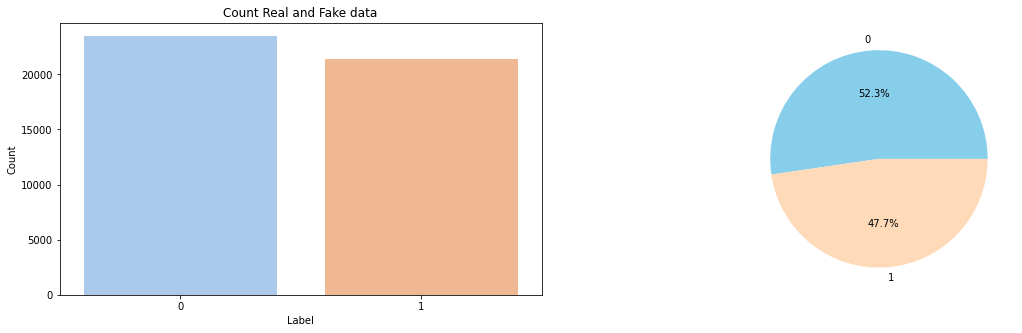

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(data.label,ax=ax[0],palette="pastel");
g1.set_title("Count Real and Fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Label")
g2 = plt.pie(data["label"].value_counts().values,explode=[0,0],labels=data.label.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()
print(data["label"].value_counts())

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

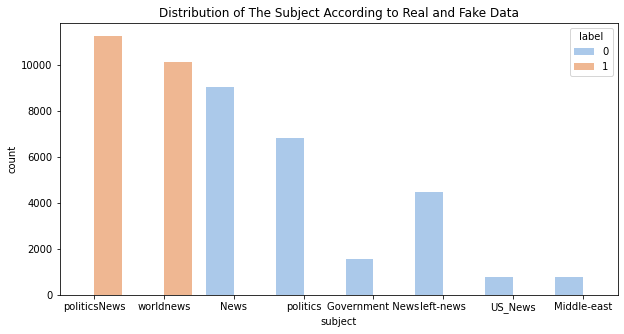

In [ ]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='label', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

In [ ]:
data['text']= data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [ ]:
sample_text = data.text[8]

In [ ]:
sample_text

'Trump on Twitter (Dec 28) - Global Warming The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - Together, we are MAKING AMERICA GREAT AGAIN! bit.ly/2lnpKaq [1814 EST] - In the East, it could be the COLDEST New Year’s Eve on record. Perhaps we could use a little bit of that good old Global Warming that our Country, but not other countries, was going to pay TRILLIONS OF DOLLARS to protect against. Bundle up! [1901 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

In [ ]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sample_text, "html.parser")
sample_text = soup.get_text()
sample_text

'Trump on Twitter (Dec 28) - Global Warming The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - Together, we are MAKING AMERICA GREAT AGAIN! bit.ly/2lnpKaq [1814 EST] - In the East, it could be the COLDEST New Year’s Eve on record. Perhaps we could use a little bit of that good old Global Warming that our Country, but not other countries, was going to pay TRILLIONS OF DOLLARS to protect against. Bundle up! [1901 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

In [ ]:
sample_text = re.sub('\[[^]]*\]', ' ', sample_text)
sample_text = re.sub('[^a-zA-Z]',' ',sample_text)  # replaces non-alphabets with spaces
sample_text = sample_text.lower() # Converting from uppercase to lowercase
sample_text

'trump on twitter  dec       global warming the following statements were posted to the verified twitter accounts of u s  president donald trump   realdonaldtrump and  potus   the opinions expressed are his own  reuters has not edited the statements or confirmed their accuracy    realdonaldtrump     together  we are making america great again  bit ly  lnpkaq     in the east  it could be the coldest new year s eve on record  perhaps we could use a little bit of that good old global warming that our country  but not other countries  was going to pay trillions of dollars to protect against  bundle up       source link   bit ly  jbh lu   bit ly  jpexyr  '

In [ ]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sample_text = nltk.word_tokenize(sample_text)

In [ ]:
sample_text = [ word for word in sample_text if not word in set(stopwords.words("english"))]

In [ ]:
nltk.download('omw-1.4')
lemma = nltk.WordNetLemmatizer()
sample_text = [lemma.lemmatize(word) for word in sample_text]

sample_text = " ".join(sample_text)
sample_text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


'trump twitter dec global warming following statement posted verified twitter account u president donald trump realdonaldtrump potus opinion expressed reuters edited statement confirmed accuracy realdonaldtrump together making america great bit ly lnpkaq east could coldest new year eve record perhaps could use little bit good old global warming country country going pay trillion dollar protect bundle source link bit ly jbh lu bit ly jpexyr'

In [ ]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)

In [ ]:
#data.to_csv('cleanData.csv')
#data.to_csv('cleanDataf.csv', index=False)
drive.mount('/content/drive')

path = "/content/drive/MyDrive/cleanDataf.csv"
data = pd.read_csv(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.head()

,text,label
0,u budget fight loom republican flip fiscal scr...,1
1,u military accept transgender recruit monday p...,1
2,senior u republican senator let mr mueller job...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump want postal service charge much amazon s...,1


In [ ]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

def get_length_words(text):
    text = str(text)
    return len(text.split(' '))


In [ ]:
data['length_alphabets'] = data['text'].apply(get_length_alphabets)
data['length_words'] = data['text'].apply(get_length_words)

In [ ]:
data.head()

,text,label,length_alphabets,length_words
0,u budget fight loom republican flip fiscal scr...,1,3305,448
1,u military accept transgender recruit monday p...,1,3023,384
2,senior u republican senator let mr mueller job...,1,1981,270
3,fbi russia probe helped australian diplomat ti...,1,1816,238
4,trump want postal service charge much amazon s...,1,3624,502


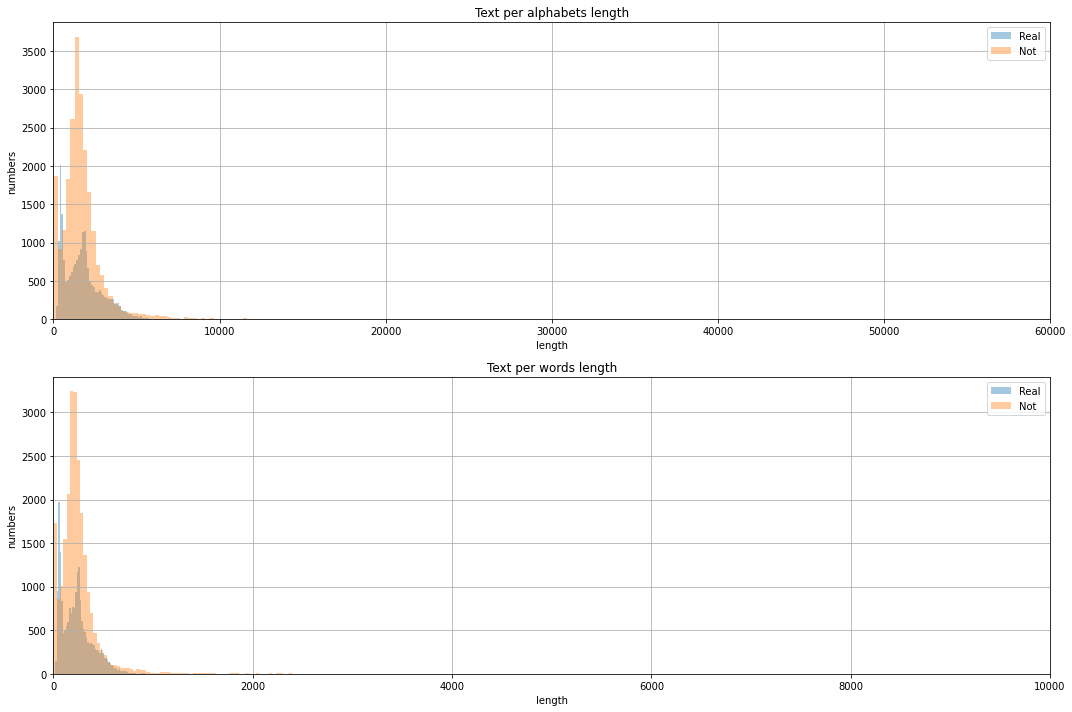

In [ ]:
f, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].set_title('Text per alphabets length')
ax[0].hist(data[data['label'] == 1]['length_alphabets'], alpha = 0.4, bins=150, label = 'Real')
ax[0].hist(data[data['label'] == 0]['length_alphabets'], alpha = 0.4, bins=150, label = 'Not')
ax[0].set_xlabel('length')
ax[0].set_ylabel('numbers')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,60000)
ax[0].grid()

ax[1].set_title('Text per words length')
ax[1].hist(data[data['label'] == 1]['length_words'], alpha = 0.4, bins=150, label = 'Real')
ax[1].hist(data[data['label'] == 0]['length_words'], alpha = 0.4, bins=150, label = 'Not')
ax[1].set_xlabel('length')
ax[1].set_ylabel('numbers')
ax[1].legend(loc='upper right')
ax[1].set_xlim(0,10000)
ax[1].grid()

f.tight_layout()
plt.show()

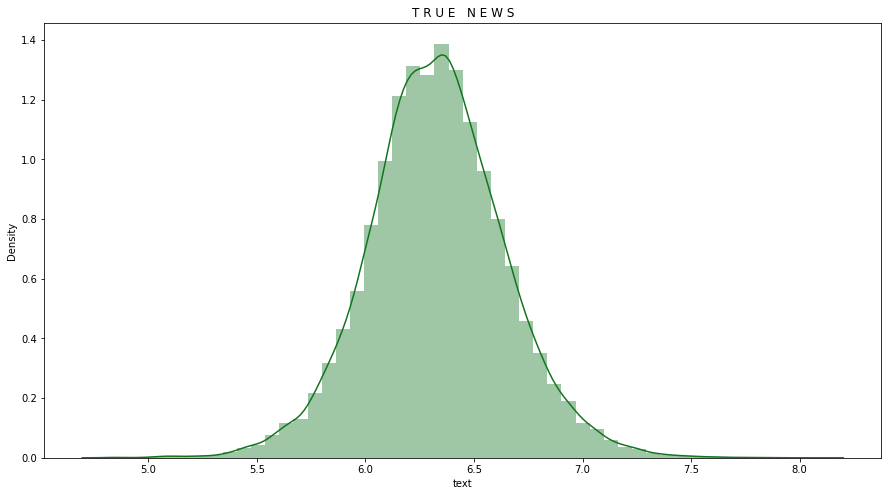

In [ ]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = data[data["label"] == 1]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#12741F", ax = ax).set_title("T R U E   N E W S");

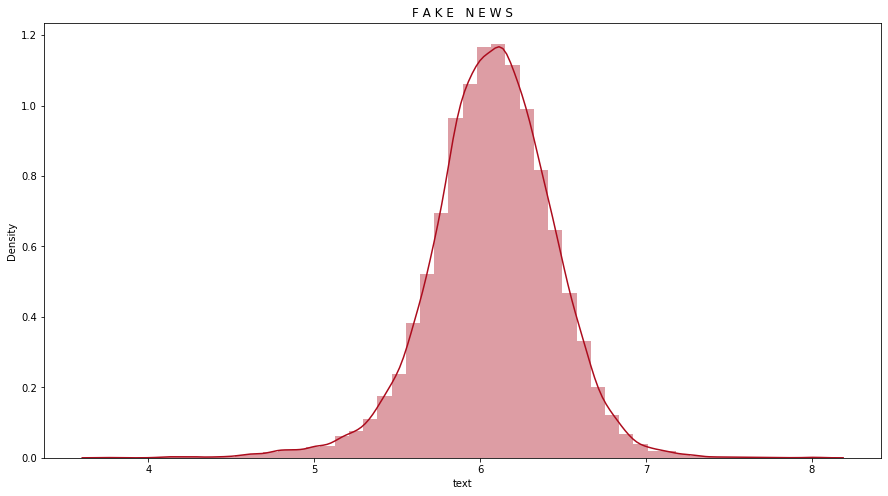

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8))
text_words = data[data["label"] == 0]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#AC0C1D", ax = ax).set_title("F A K E   N E W S");

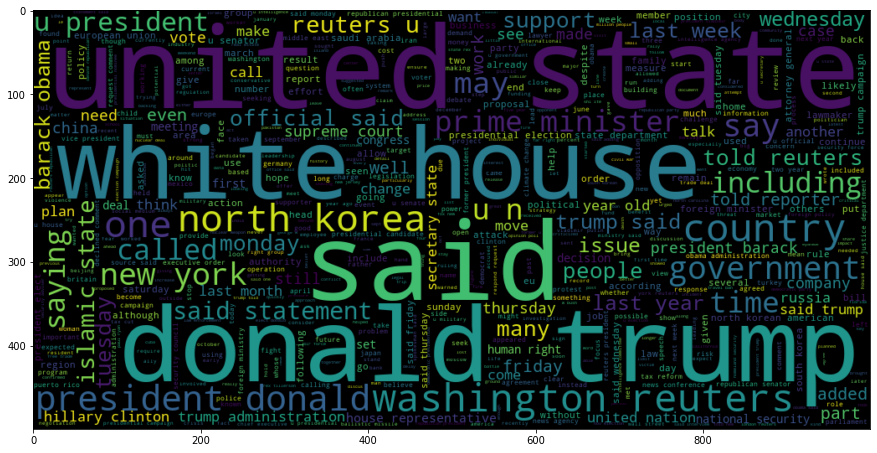

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 600 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

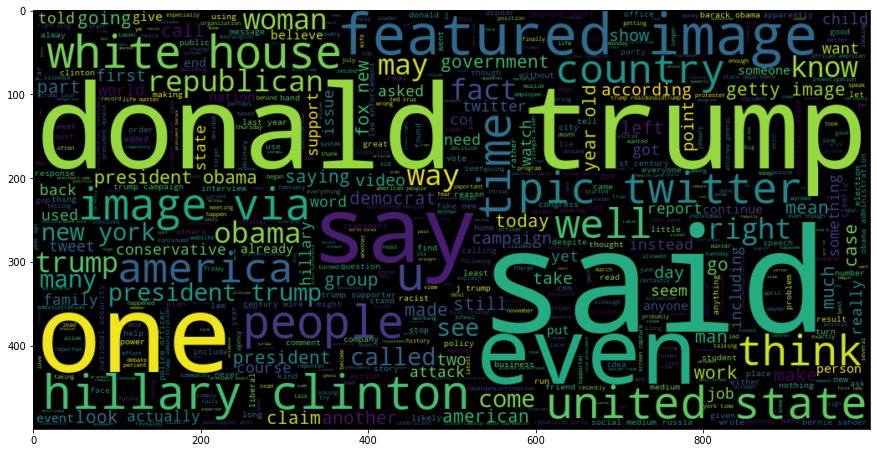

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 600 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

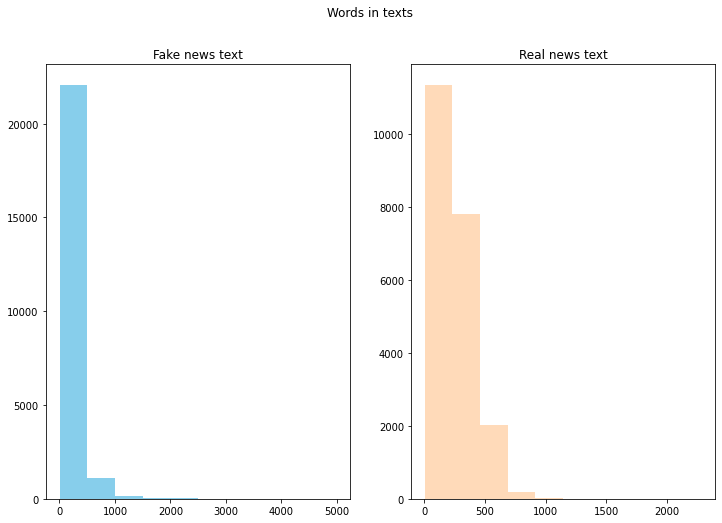

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

In [ ]:
texts = ' '.join(data['text'])

In [ ]:
string = texts.split(" ")

In [ ]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

           word   count
0      (trump,)  149603
1       (said,)  133030
2          (u,)   77733
3      (state,)   62726
4  (president,)   58790


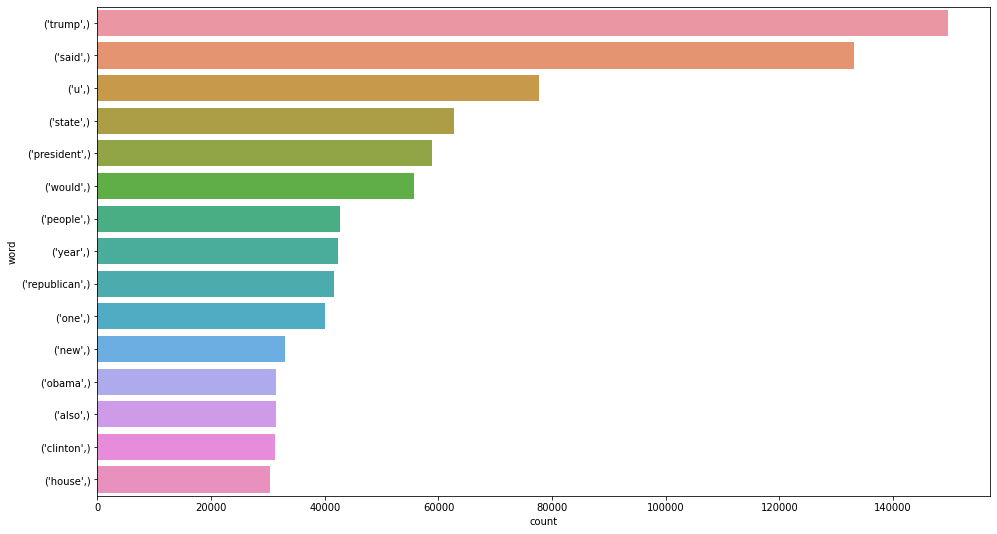

In [ ]:
draw_n_gram(string,1)

                 word  count
0     (donald, trump)  25203
1     (united, state)  18943
2      (white, house)  16296
3  (hillary, clinton)  10217
4         (new, york)   9305


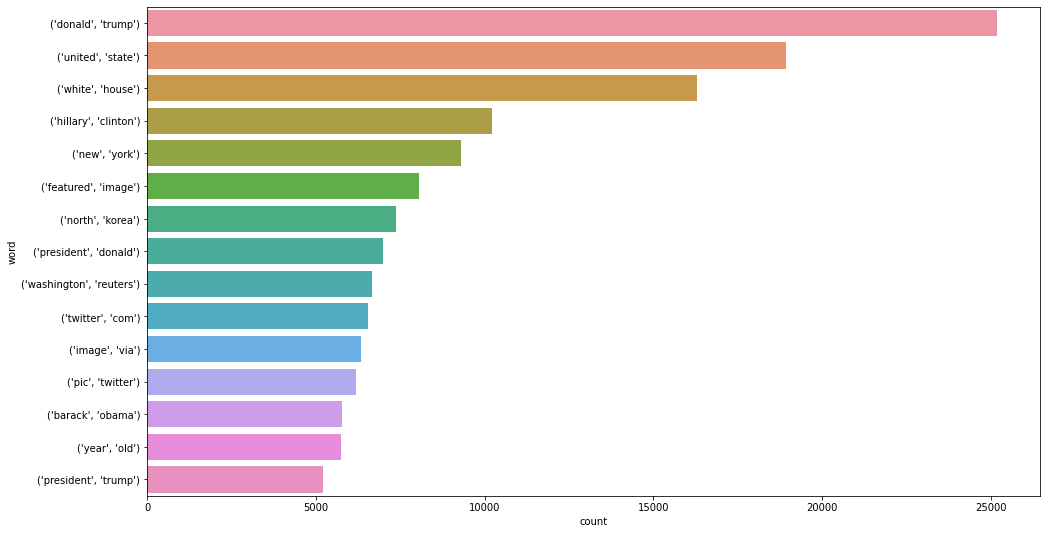

In [ ]:
draw_n_gram(string,2)

                         word  count
0  (president, donald, trump)   6830
1         (pic, twitter, com)   6185
2      (featured, image, via)   6029
3  (president, barack, obama)   3911
4      (u, president, donald)   2594


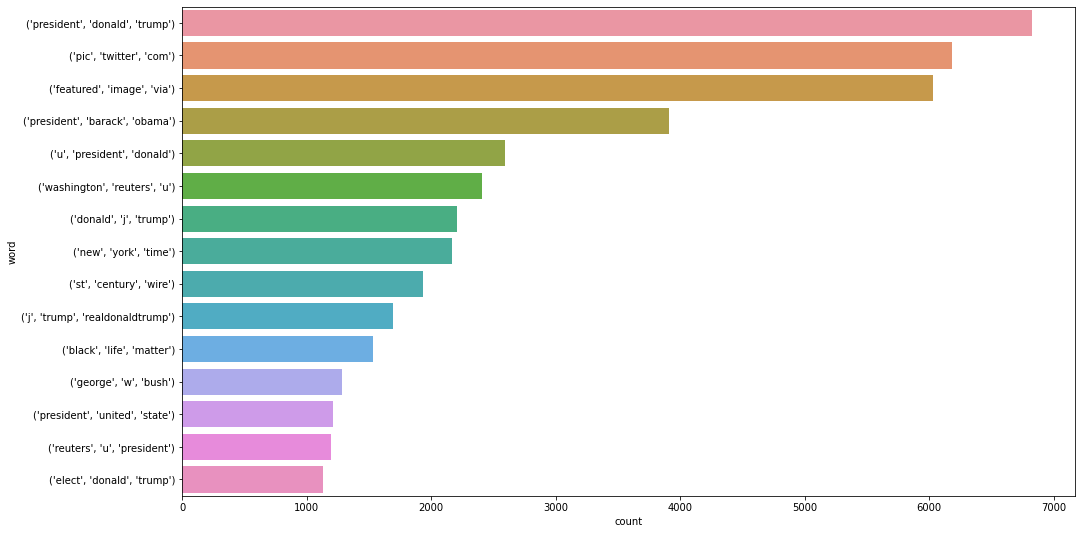

In [ ]:
draw_n_gram(string,3)

                                  word  count
0        (u, president, donald, trump)   2594
1  (donald, j, trump, realdonaldtrump)   1692
2    (president, elect, donald, trump)   1095
3            (news, st, century, wire)    953
4      (reuters, u, president, donald)    867


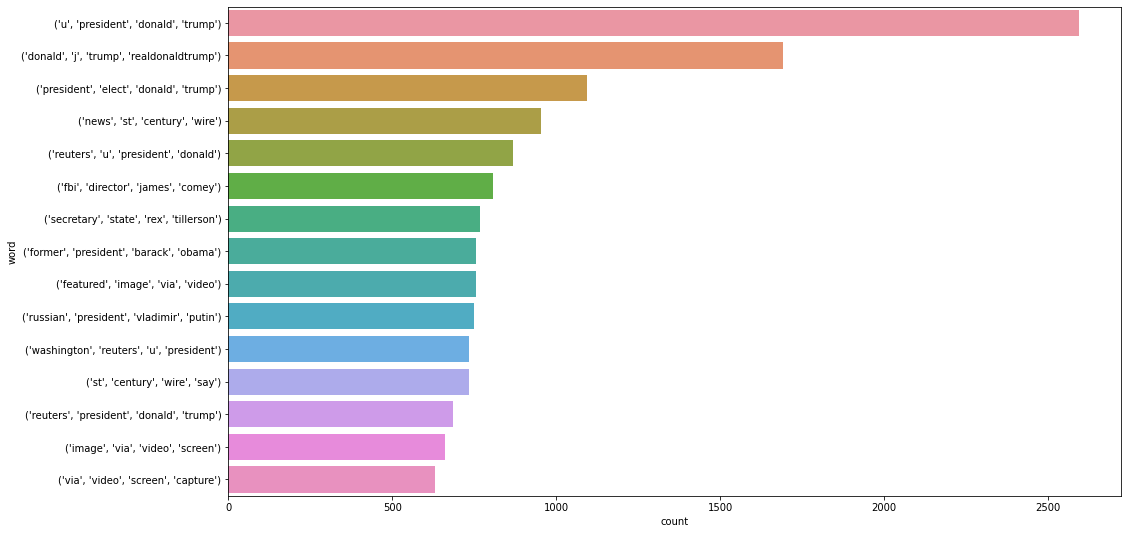

In [ ]:
draw_n_gram(string,4)

In [ ]:
data['text']

0        u budget fight loom republican flip fiscal scr...
1        u military accept transgender recruit monday p...
2        senior u republican senator let mr mueller job...
3        fbi russia probe helped australian diplomat ti...
4        trump want postal service charge much amazon s...
                               ...                        
44893    mcpain john mccain furious iran treated u sail...
44894    justice yahoo settle e mail privacy class acti...
44895    sunnistan u allied safe zone plan take territo...
44896    blow million al jazeera america finally call q...
44897    u navy sailor held iranian military sign neoco...
Name: text, Length: 44898, dtype: object

In [ ]:
text_len_fake=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
text_len_real=data[data['label']==1]['text'].str.split().map(lambda x: len(x))

In [ ]:
text_len_real.values.max()

2283

In [ ]:
text_len_fake.values.max()

4989

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], random_state=0)

In [ ]:
text

<module 'keras.preprocessing.text' from '/usr/local/lib/python3.7/dist-packages/keras/preprocessing/text.py'>

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
import pickle
with open("/content/drive/MyDrive/tokenizer300mxlenn.h5", 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
import pickle
with open('tokenizer300mxlen.h5','wb') as f:
  pickle.dump(tokenizer,f)

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
model = Sequential()

model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
model.add(LSTM(50,dropout = 0.2,recurrent_dropout = 0.2))
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 105       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,031,331
Trainable params: 31,331
Non-t

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 129s 1s/step - loss: 0.4317 - accuracy: 0.8007 - val_loss: 0.3365 - val_accuracy: 0.8420
Epoch 2/10
93/93 [==============================] - 126s 1s/step - loss: 0.2909 - accuracy: 0.8773 - val_loss: 0.2935 - val_accuracy: 0.8699
Epoch 3/10
93/93 [==============================] - 125s 1s/step - loss: 0.2509 - accuracy: 0.8992 - val_loss: 0.2176 - val_accuracy: 0.9216
Epoch 4/10
93/93 [==============================] - 125s 1s/step - loss: 0.2320 - accuracy: 0.9152 - val_loss: 0.1868 - val_accuracy: 0.9348
Epoch 5/10
93/93 [==============================] - 125s 1s/step - loss: 0.2019 - accuracy: 0.9230 - val_loss: 0.1657 - val_accuracy: 0.9413
Epoch 6/10
93/93 [==============================] - 125s 1s/step - loss: 0.1860 - accuracy: 0.9267 - val_loss: 0.2706 - val_accuracy: 0.8903
Epoch 7/10
93/93 [==============================] - 124s 1s/step - loss: 0.2655 - accuracy: 0.8930 - val_loss: 0.3692 - val_accuracy: 0.8216
Epoch 8/10
93

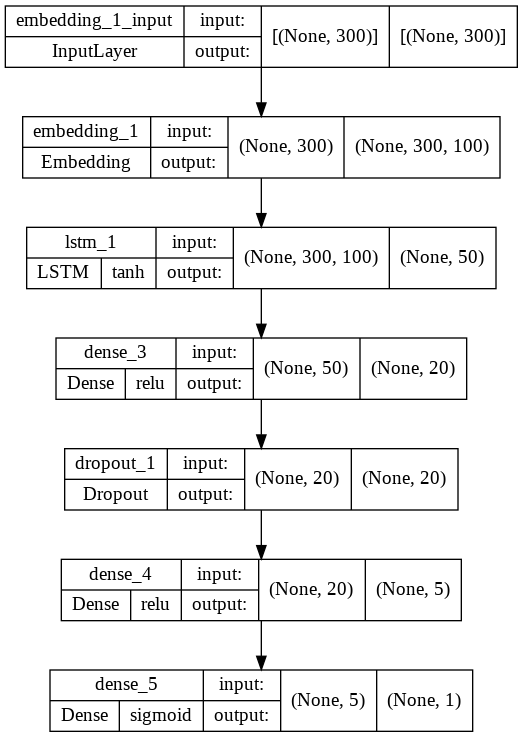

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model1lstm.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 60s 57ms/step - loss: 0.6706 - accuracy: 0.5690
Accuracy of the model on Training Data is -  56.903159618377686 %
351/351 [==============================] - 20s 56ms/step - loss: 0.6687 - accuracy: 0.5705
Accuracy of the model on Testing Data is -  57.05122351646423 %


In [ ]:
model.save('lstm1f.h5')

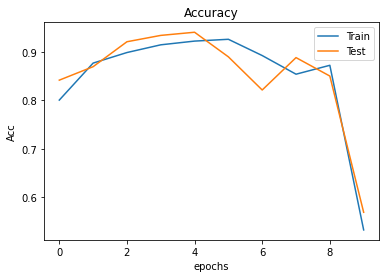

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

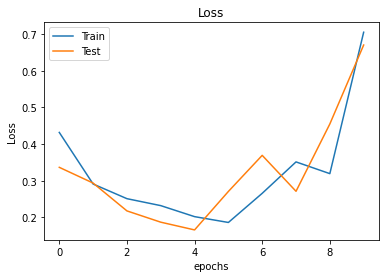

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.55      0.98      0.70      5858
        Real       0.85      0.12      0.21      5367

    accuracy                           0.57     11225
   macro avg       0.70      0.55      0.46     11225
weighted avg       0.69      0.57      0.47     11225



In [ ]:
confusion_matrix(y_test,pred)

array([[5745,  113],
       [4708,  659]])

Text(42.0, 0.5, 'Actual')

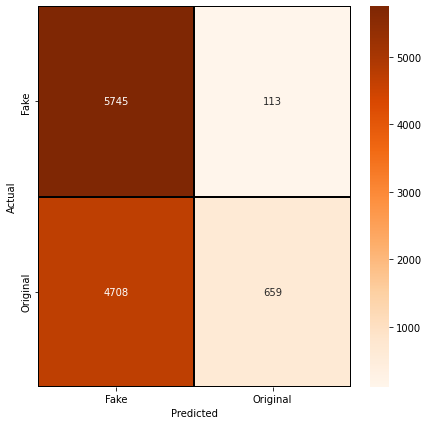

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
model_trainable_embedding = Sequential()

model_trainable_embedding.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=True))
model_trainable_embedding.add(LSTM(50,dropout = 0.2,recurrent_dropout = 0.2))
model_trainable_embedding.add(Dense(20,activation='relu'))
model_trainable_embedding.add(Dropout(0.2))
model_trainable_embedding.add(Dense(5,activation='relu'))
model_trainable_embedding.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model_trainable_embedding.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model_trainable_embedding.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 105       
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,031,331
Trainable params: 1,031,331
No

In [ ]:
history_trainable_embedding = model_trainable_embedding.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 152s 2s/step - loss: 0.2537 - accuracy: 0.9152 - val_loss: 0.0899 - val_accuracy: 0.9725
Epoch 2/10
93/93 [==============================] - 143s 2s/step - loss: 0.0622 - accuracy: 0.9807 - val_loss: 0.0848 - val_accuracy: 0.9745
Epoch 3/10
93/93 [==============================] - 142s 2s/step - loss: 0.0441 - accuracy: 0.9871 - val_loss: 0.0851 - val_accuracy: 0.9715
Epoch 4/10
93/93 [==============================] - 141s 2s/step - loss: 0.0290 - accuracy: 0.9919 - val_loss: 0.0547 - val_accuracy: 0.9858
Epoch 5/10
93/93 [==============================] - 141s 2s/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.0557 - val_accuracy: 0.9857
Epoch 6/10
93/93 [==============================] - 141s 2s/step - loss: 0.0111 - accuracy: 0.9968 - val_loss: 0.0536 - val_accuracy: 0.9871
Epoch 7/10
93/93 [==============================] - 141s 2s/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0566 - val_accuracy: 0.9901
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , model_trainable_embedding.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model_trainable_embedding.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 64s 60ms/step - loss: 0.0251 - accuracy: 0.9951
Accuracy of the model on Training Data is -  99.5070219039917 %
351/351 [==============================] - 20s 57ms/step - loss: 0.0791 - accuracy: 0.9856
Accuracy of the model on Testing Data is -  98.55679273605347 %


In [ ]:
model_trainable_embedding.save('lstm1f_model_trainable_embedding.h5')

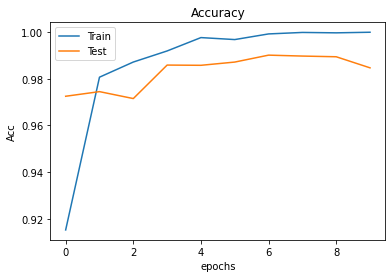

In [ ]:
plt.figure()
plt.plot(history_trainable_embedding.history["accuracy"], label = "Train")
plt.plot(history_trainable_embedding.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

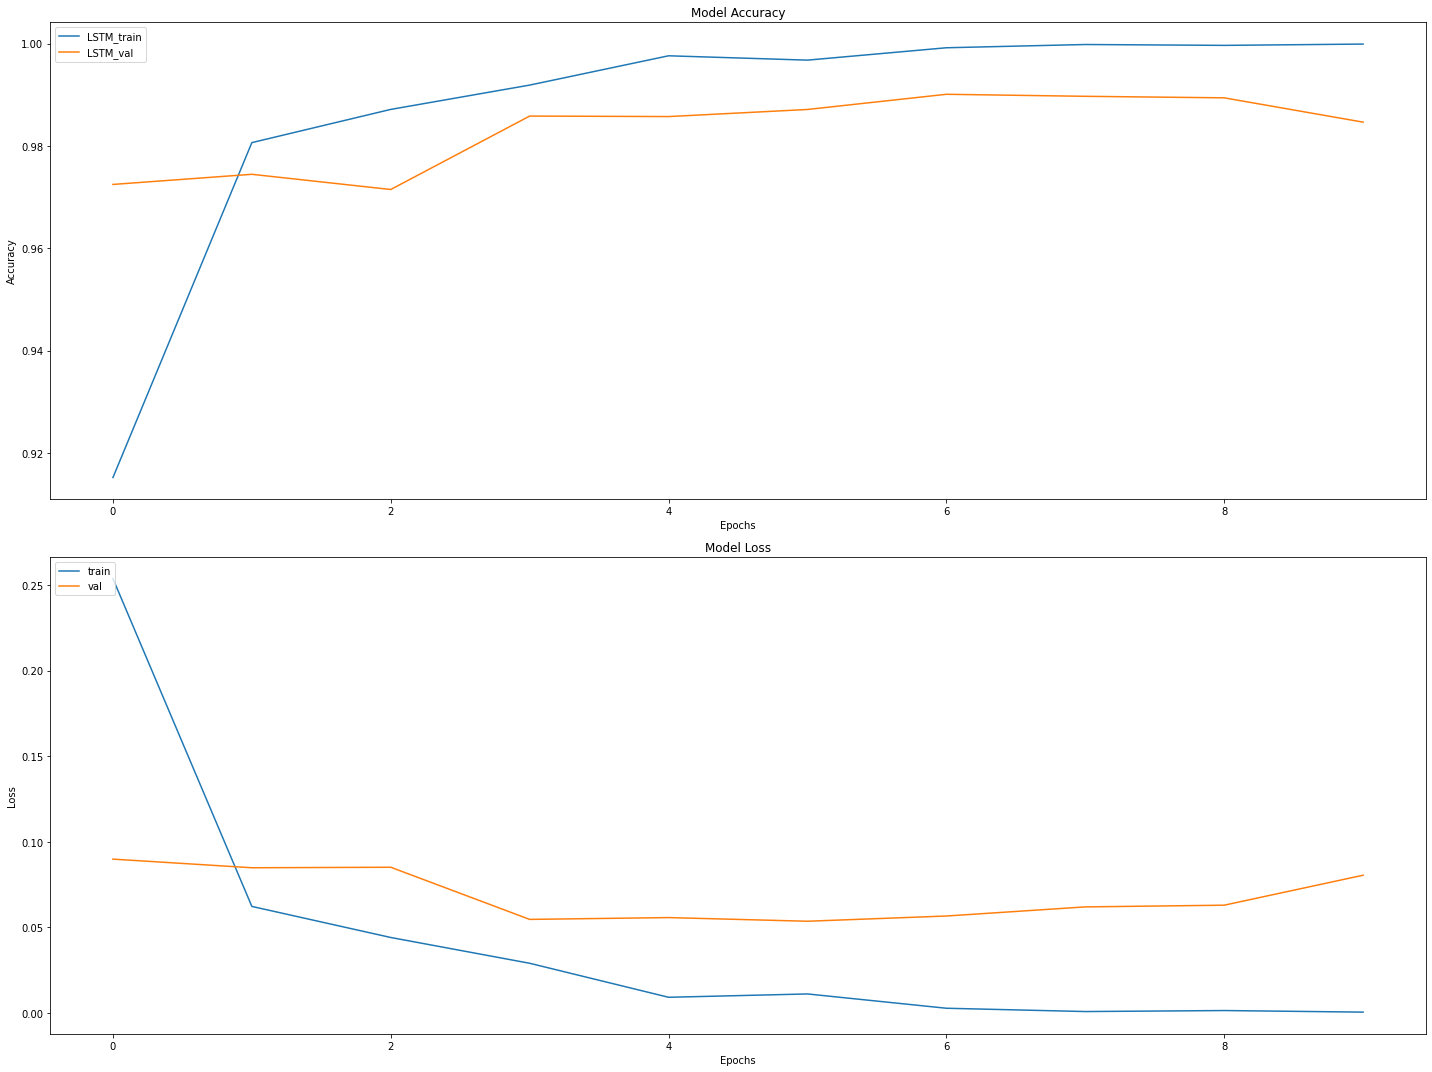

In [ ]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history_trainable_embedding.history['accuracy'])
ax[0].plot(history_trainable_embedding.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history_trainable_embedding.history['loss'])
ax[1].plot(history_trainable_embedding.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

In [ ]:
model_trainable_embedding_with_moreDropout = Sequential()

model_trainable_embedding_with_moreDropout.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=True))
model_trainable_embedding_with_moreDropout.add(LSTM(50,dropout = 0.3,recurrent_dropout = 0.2))
model_trainable_embedding_with_moreDropout.add(Dense(20,activation='relu'))
model_trainable_embedding_with_moreDropout.add(Dropout(0.4))
model_trainable_embedding_with_moreDropout.add(Dense(5,activation='relu'))
model_trainable_embedding_with_moreDropout.add(Dropout(0.2))
model_trainable_embedding_with_moreDropout.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model_trainable_embedding_with_moreDropout.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model_trainable_embedding_with_moreDropout.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dense_12 (Dense)            (None, 20)                1020      
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 5)                 105       
                                                                 
 dropout_5 (Dropout)         (None, 5)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                

In [ ]:
history_trainable_embedding_with_moreDropout = model_trainable_embedding_with_moreDropout.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 152s 2s/step - loss: 0.2583 - accuracy: 0.9252 - val_loss: 0.1187 - val_accuracy: 0.9667
Epoch 2/10
93/93 [==============================] - 141s 2s/step - loss: 0.1677 - accuracy: 0.9540 - val_loss: 0.1278 - val_accuracy: 0.9509
Epoch 3/10
93/93 [==============================] - 141s 2s/step - loss: 0.0877 - accuracy: 0.9844 - val_loss: 0.1456 - val_accuracy: 0.9765
Epoch 4/10
93/93 [==============================] - 141s 2s/step - loss: 0.0579 - accuracy: 0.9899 - val_loss: 0.0830 - val_accuracy: 0.9876
Epoch 5/10
93/93 [==============================] - 145s 2s/step - loss: 0.0348 - accuracy: 0.9954 - val_loss: 0.0664 - val_accuracy: 0.9865
Epoch 6/10
93/93 [==============================] - 142s 2s/step - loss: 0.0262 - accuracy: 0.9969 - val_loss: 0.0880 - val_accuracy: 0.9887
Epoch 7/10
93/93 [==============================] - 141s 2s/step - loss: 0.0161 - accuracy: 0.9983 - val_loss: 0.0858 - val_accuracy: 0.9898
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , model_trainable_embedding_with_moreDropout.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model_trainable_embedding_with_moreDropout.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 60s 57ms/step - loss: 0.0268 - accuracy: 0.9964
Accuracy of the model on Training Data is -  99.6406614780426 %
351/351 [==============================] - 20s 56ms/step - loss: 0.0876 - accuracy: 0.9879
Accuracy of the model on Testing Data is -  98.78841638565063 %


In [ ]:
model_trainable_embedding_with_moreDropout.save('lstm1f_model_trainable_embedding_with_moreDropout.h5')

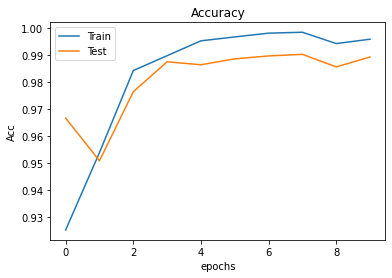

In [ ]:
plt.figure()
plt.plot(history_trainable_embedding_with_moreDropout.history["accuracy"], label = "Train")
plt.plot(history_trainable_embedding_with_moreDropout.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

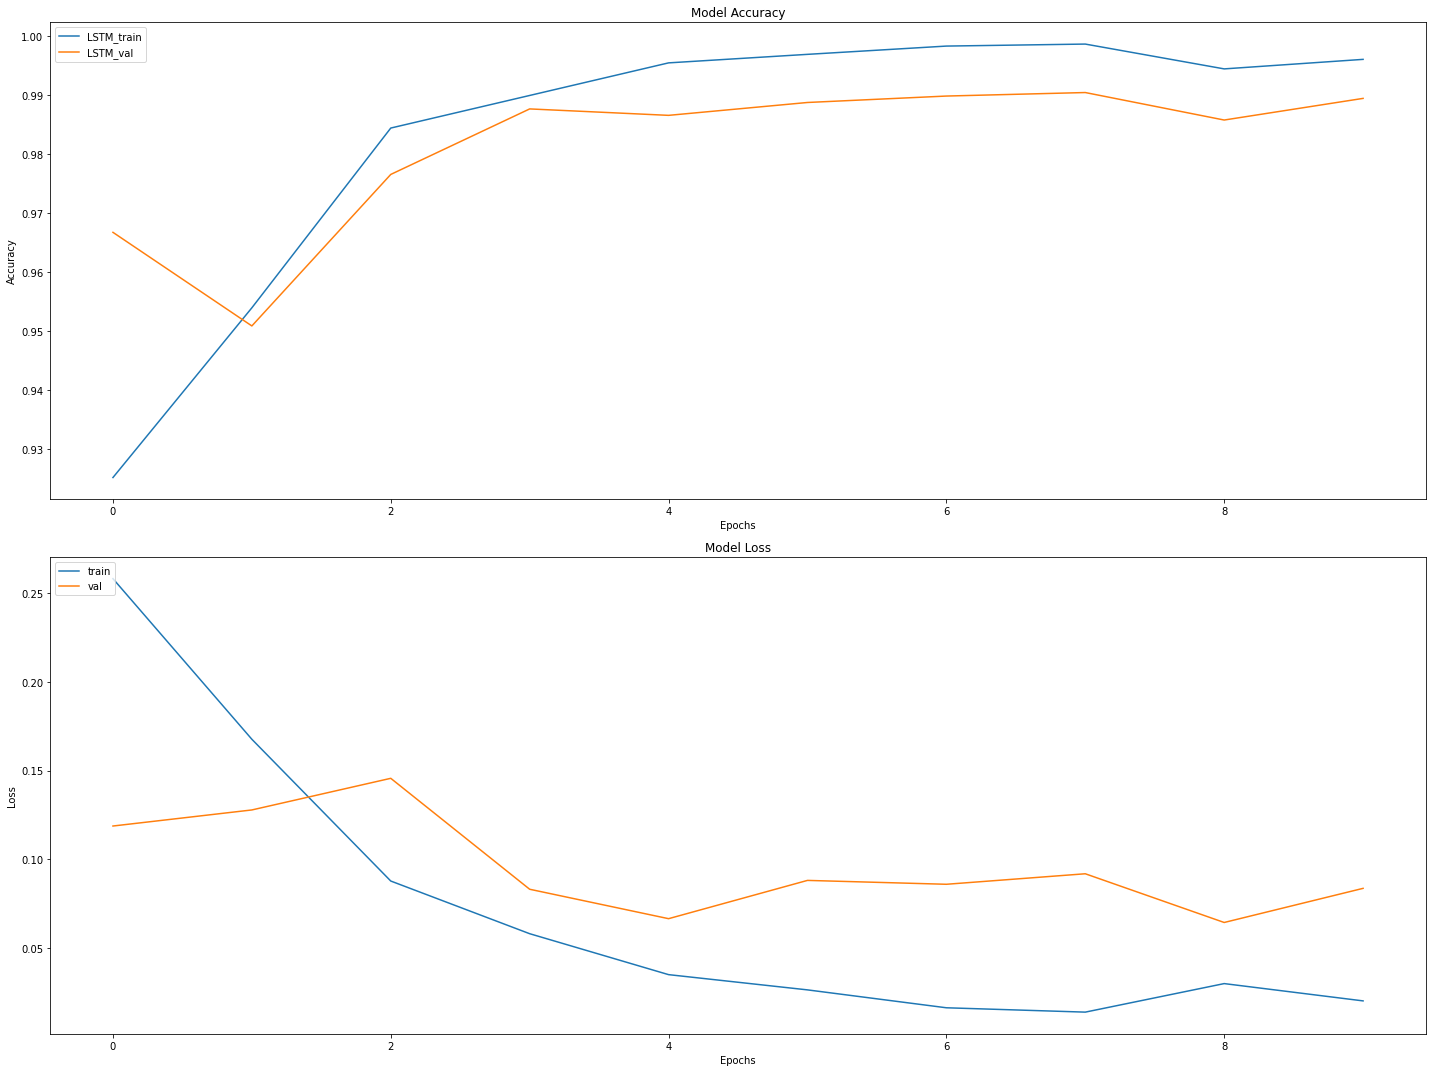

In [ ]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history_trainable_embedding_with_moreDropout.history['accuracy'])
ax[0].plot(history_trainable_embedding_with_moreDropout.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history_trainable_embedding_with_moreDropout.history['loss'])
ax[1].plot(history_trainable_embedding_with_moreDropout.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

In [ ]:
# finish network with one lstm layer

In [ ]:
# one lstm layer + Glove pretrained

In [ ]:
GLOVE_EMBEDDING = "/content/drive/MyDrive/glove.twitter.27B.100d.txt"

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))

In [ ]:
embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(10000, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model2 = Sequential()

model2.add(Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False))
model2.add(LSTM(50,dropout = 0.2,recurrent_dropout = 0.2))
model2.add(Dense(20,activation='relu'))
model2.add(Dense(5,activation='relu'))

model2.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model2.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 5)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,031,331
Trainable params: 31,331
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history2 = model2.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 129s 1s/step - loss: 0.2344 - accuracy: 0.9197 - val_loss: 0.0789 - val_accuracy: 0.9752
Epoch 2/10
93/93 [==============================] - 125s 1s/step - loss: 0.0713 - accuracy: 0.9768 - val_loss: 0.0405 - val_accuracy: 0.9886
Epoch 3/10
93/93 [==============================] - 125s 1s/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0267 - val_accuracy: 0.9913
Epoch 4/10
93/93 [==============================] - 123s 1s/step - loss: 0.0229 - accuracy: 0.9921 - val_loss: 0.0226 - val_accuracy: 0.9926
Epoch 5/10
93/93 [==============================] - 127s 1s/step - loss: 0.0201 - accuracy: 0.9928 - val_loss: 0.0193 - val_accuracy: 0.9944
Epoch 6/10
93/93 [==============================] - 124s 1s/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0210 - val_accuracy: 0.9944
Epoch 7/10
93/93 [==============================] - 124s 1s/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0175 - val_accuracy: 0.9950
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , model2.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model2.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 63s 60ms/step - loss: 0.0102 - accuracy: 0.9971
Accuracy of the model on Training Data is -  99.71490502357483 %
351/351 [==============================] - 22s 61ms/step - loss: 0.0210 - accuracy: 0.9946
Accuracy of the model on Testing Data is -  99.45657253265381 %


In [ ]:
model2.save('lstm1withGlove.h5')

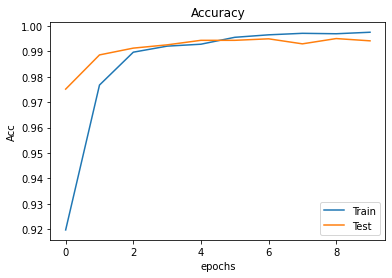

In [ ]:
plt.figure()
plt.plot(history2.history["accuracy"], label = "Train")
plt.plot(history2.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

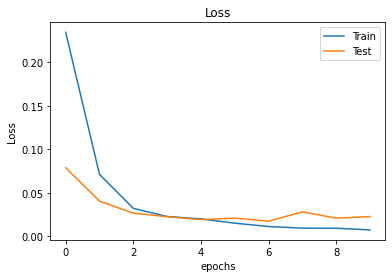

In [ ]:
plt.figure()
plt.plot(history2.history["loss"], label = "Train")
plt.plot(history2.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model2.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99      5858
        Real       1.00      0.99      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Text(42.0, 0.5, 'Actual')

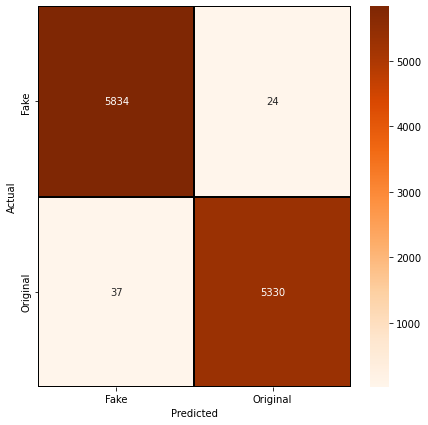

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
# start network with stacked lstm layers

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve,roc_auc_score

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

In [ ]:
model3 = Sequential()
#Embedding layer
model3.add(Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False))
#LSTM
model3.add(LSTM(units = 128, activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences = True, recurrent_dropout = 0.1, dropout = 0.25 ))
model3.add(LSTM(units = 64,activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0.1, dropout = 0.1))
model3.add(Dense(units = 32, activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-

In [ ]:
history3 = model3.fit(X_train, y_train, batch_size = batch_size , validation_split = 0.3 , epochs = epochs , callbacks = [lr_reduce], shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 459s 5s/step - loss: 0.2570 - accuracy: 0.8951 - val_loss: 0.1705 - val_accuracy: 0.9421 - lr: 0.0100
Epoch 2/10
93/93 [==============================] - 452s 5s/step - loss: 0.1043 - accuracy: 0.9642 - val_loss: 0.0474 - val_accuracy: 0.9857 - lr: 0.0100
Epoch 3/10
93/93 [==============================] - 449s 5s/step - loss: 0.0578 - accuracy: 0.9812 - val_loss: 0.0749 - val_accuracy: 0.9813 - lr: 0.0100
Epoch 4/10
93/93 [==============================] - 448s 5s/step - loss: 0.0507 - accuracy: 0.9868 - val_loss: 0.0282 - val_accuracy: 0.9923 - lr: 0.0100
Epoch 5/10
93/93 [==============================] - 450s 5s/step - loss: 0.0275 - accuracy: 0.9910 - val_loss: 0.0258 - val_accuracy: 0.9945 - lr: 0.0100
Epoch 6/10
93/93 [==============================] - 449s 5s/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0311 - val_accuracy: 0.9921 - lr: 0.0100
Epoch 7/10
93/93 [==============================] - 453s 5s/step - loss: 0.0

In [ ]:
print("Accuracy of the model on Training Data is - " , model3.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model3.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 194s 184ms/step - loss: 0.0136 - accuracy: 0.9955
Accuracy of the model on Training Data is -  99.55157041549683 %
351/351 [==============================] - 54s 154ms/step - loss: 0.0244 - accuracy: 0.9922
Accuracy of the model on Testing Data is -  99.21603798866272 %


In [ ]:
model3.save('stackedlstmwithGlove.h5')

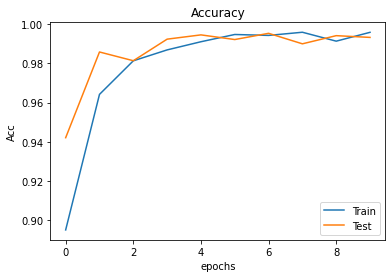

In [ ]:
plt.figure()
plt.plot(history3.history["accuracy"], label = "Train")
plt.plot(history3.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

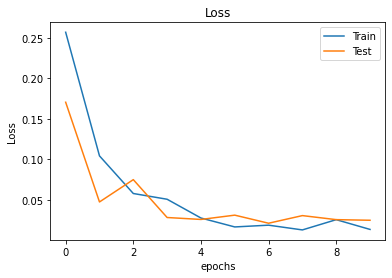

In [ ]:
plt.figure()
plt.plot(history3.history["loss"], label = "Train")
plt.plot(history3.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model3.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      5858
        Real       0.99      1.00      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Text(42.0, 0.5, 'Actual')

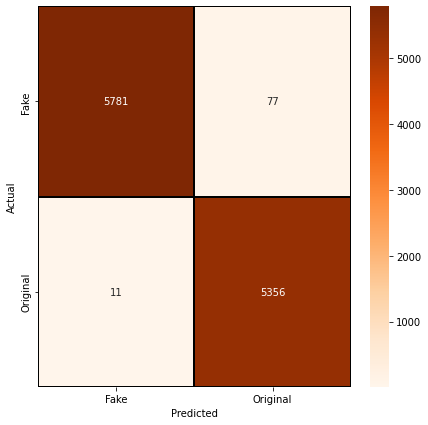

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
## finish

In [ ]:
## start BiLstm + Glove

In [ ]:
from keras import layers

In [ ]:
model4 = Sequential()

model4.add(Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False))
model4.add(layers.Bidirectional(LSTM(50,dropout = 0.2,recurrent_dropout = 0.2)))
model4.add(Dense(20,activation='relu'))
model4.add(Dropout(0.3)) #enhance
model4.add(Dense(5,activation='relu'))
model4.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model4.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model4.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 20)                2020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 105       
                                                                 
 dense_10 (Dense)            (None, 1)                 6         
                                                      

In [ ]:
history4 = model4.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 260s 3s/step - loss: 0.2624 - accuracy: 0.8929 - val_loss: 0.3919 - val_accuracy: 0.8458
Epoch 2/10
93/93 [==============================] - 254s 3s/step - loss: 0.0998 - accuracy: 0.9654 - val_loss: 0.0380 - val_accuracy: 0.9883
Epoch 3/10
93/93 [==============================] - 251s 3s/step - loss: 0.0385 - accuracy: 0.9867 - val_loss: 0.0258 - val_accuracy: 0.9913
Epoch 4/10
93/93 [==============================] - 253s 3s/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 0.0273 - val_accuracy: 0.9914
Epoch 5/10
93/93 [==============================] - 253s 3s/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0212 - val_accuracy: 0.9949
Epoch 6/10
93/93 [==============================] - 253s 3s/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.0230 - val_accuracy: 0.9932
Epoch 7/10
93/93 [==============================] - 250s 3s/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0250 - val_accuracy: 0.9947
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , model4.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model4.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 110s 104ms/step - loss: 0.0080 - accuracy: 0.9981
Accuracy of the model on Training Data is -  99.80696439743042 %
351/351 [==============================] - 36s 102ms/step - loss: 0.0176 - accuracy: 0.9949
Accuracy of the model on Testing Data is -  99.49220418930054 %


In [ ]:
model4.save('BiLstmWithGlove.h5')

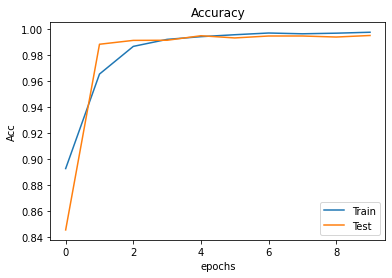

In [ ]:
plt.figure()
plt.plot(history4.history["accuracy"], label = "Train")
plt.plot(history4.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

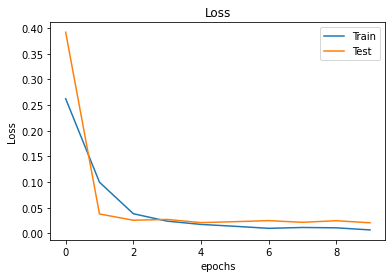

In [ ]:
plt.figure()
plt.plot(history4.history["loss"], label = "Train")
plt.plot(history4.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model4.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      5858
        Real       0.99      1.00      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      1.00      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Text(42.0, 0.5, 'Actual')

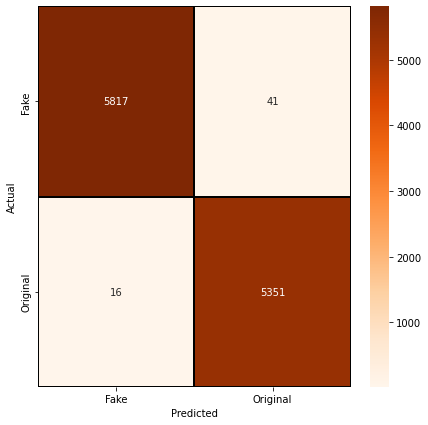

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
## finish

In [ ]:
## Start GRU

In [ ]:
model5 = Sequential()

model5.add(Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False))
model5.add(layers.GRU(50,dropout = 0.2,recurrent_dropout = 0.2))
model5.add(Dense(20,activation='relu'))
model5.add(Dropout(0.2)) #enhance
model5.add(Dense(5,activation='relu'))
model5.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model5.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model5.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 gru (GRU)                   (None, 50)                22800     
                                                                 
 dense_11 (Dense)            (None, 20)                1020      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_12 (Dense)            (None, 5)                 105       
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,023,931
Trainable params: 23,931
Non-t

In [ ]:
history5 = model5.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 115s 1s/step - loss: 0.1592 - accuracy: 0.9381 - val_loss: 0.0223 - val_accuracy: 0.9924
Epoch 2/10
93/93 [==============================] - 108s 1s/step - loss: 0.0293 - accuracy: 0.9901 - val_loss: 0.0225 - val_accuracy: 0.9914
Epoch 3/10
93/93 [==============================] - 105s 1s/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0199 - val_accuracy: 0.9944
Epoch 4/10
93/93 [==============================] - 106s 1s/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0182 - val_accuracy: 0.9938
Epoch 5/10
93/93 [==============================] - 107s 1s/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0214 - val_accuracy: 0.9947
Epoch 6/10
93/93 [==============================] - 107s 1s/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0167 - val_accuracy: 0.9950
Epoch 7/10
93/93 [==============================] - 107s 1s/step - loss: 0.0090 - accuracy: 0.9969 - val_loss: 0.0211 - val_accuracy: 0.9945
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , model5.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model5.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 63s 60ms/step - loss: 0.0063 - accuracy: 0.9987
Accuracy of the model on Training Data is -  99.8663604259491 %
351/351 [==============================] - 26s 73ms/step - loss: 0.0174 - accuracy: 0.9965
Accuracy of the model on Testing Data is -  99.65255856513977 %


In [ ]:
model5.save('GruWithGlove.h5')

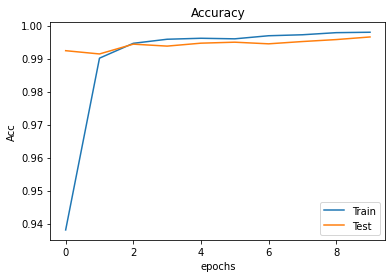

In [ ]:
plt.figure()
plt.plot(history5.history["accuracy"], label = "Train")
plt.plot(history5.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

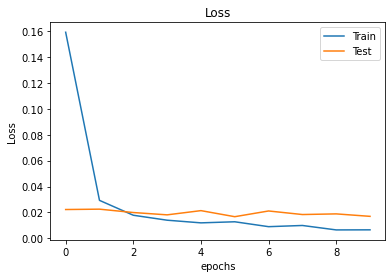

In [ ]:
plt.figure()
plt.plot(history5.history["loss"], label = "Train")
plt.plot(history5.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model5.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
        Real       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Text(42.0, 0.5, 'Actual')

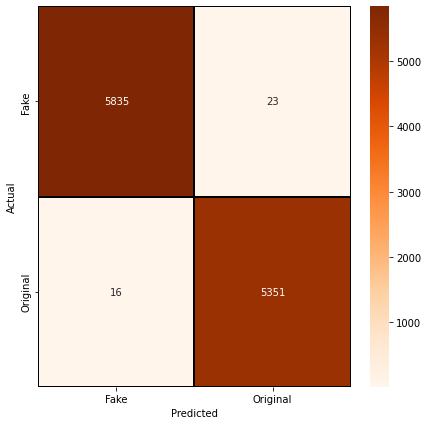

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
model6 = Sequential()

model6.add(Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False))
model6.add(layers.Bidirectional(layers.GRU(50,dropout = 0.2,recurrent_dropout = 0.2)))
model6.add(Dense(20,activation='relu'))
model6.add(Dropout(0.2)) #enhance
model6.add(Dense(5,activation='relu'))
model6.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model6.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model6.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100)              45600     
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 20)                2020      
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_18 (Dense)            (None, 5)                 105       
                                                                 
 dense_19 (Dense)            (None, 1)                 6         
                                                      

In [ ]:
history6 = model6.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 217s 2s/step - loss: 0.1566 - accuracy: 0.9338 - val_loss: 0.0277 - val_accuracy: 0.9910
Epoch 2/10
93/93 [==============================] - 207s 2s/step - loss: 0.0255 - accuracy: 0.9913 - val_loss: 0.0255 - val_accuracy: 0.9932
Epoch 3/10
93/93 [==============================] - 209s 2s/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.0187 - val_accuracy: 0.9950
Epoch 4/10
93/93 [==============================] - 210s 2s/step - loss: 0.0159 - accuracy: 0.9952 - val_loss: 0.0332 - val_accuracy: 0.9901
Epoch 5/10
93/93 [==============================] - 209s 2s/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0324 - val_accuracy: 0.9909
Epoch 6/10
93/93 [==============================] - 207s 2s/step - loss: 0.0113 - accuracy: 0.9960 - val_loss: 0.0163 - val_accuracy: 0.9958
Epoch 7/10
93/93 [==============================] - 210s 2s/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0194 - val_accuracy: 0.9949
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , model6.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model6.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 125s 118ms/step - loss: 0.0064 - accuracy: 0.9985
Accuracy of the model on Training Data is -  99.84557628631592 %
351/351 [==============================] - 35s 99ms/step - loss: 0.0173 - accuracy: 0.9950
Accuracy of the model on Testing Data is -  99.50111508369446 %


In [ ]:
model6.save('BiGruWithGlove.h5')

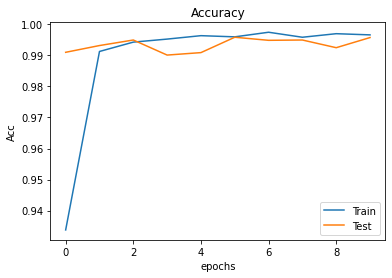

In [ ]:
plt.figure()
plt.plot(history6.history["accuracy"], label = "Train")
plt.plot(history6.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

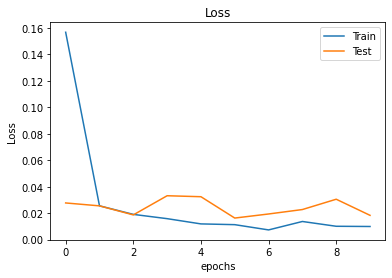

In [ ]:
plt.figure()
plt.plot(history6.history["loss"], label = "Train")
plt.plot(history6.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model6.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      5858
        Real       0.99      1.00      0.99      5367

    accuracy                           1.00     11225
   macro avg       0.99      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Text(42.0, 0.5, 'Actual')

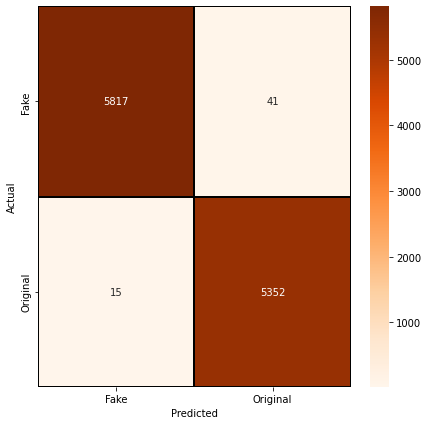

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
model7 = Sequential()

model7.add(Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False))
model7.add(layers.GRU(128,return_sequences = True,dropout = 0.2,recurrent_dropout = 0.2))
model7.add(layers.GRU(64,dropout = 0.2,recurrent_dropout = 0.1))
model7.add(Dense(20,activation='relu'))
model7.add(Dropout(0.3)) #enhance
model7.add(Dense(5,activation='relu'))
model7.add(Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model7.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model7.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 gru_4 (GRU)                 (None, 300, 128)          88320     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_20 (Dense)            (None, 20)                1300      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_21 (Dense)            (None, 5)                 105       
                                                                 
 dense_22 (Dense)            (None, 1)                

In [ ]:
history7 = model7.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 397s 4s/step - loss: 0.1555 - accuracy: 0.9320 - val_loss: 0.0222 - val_accuracy: 0.9934
Epoch 2/10
93/93 [==============================] - 380s 4s/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0225 - val_accuracy: 0.9937
Epoch 3/10
93/93 [==============================] - 379s 4s/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0208 - val_accuracy: 0.9936
Epoch 4/10
93/93 [==============================] - 383s 4s/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.0179 - val_accuracy: 0.9961
Epoch 5/10
93/93 [==============================] - 384s 4s/step - loss: 0.0118 - accuracy: 0.9971 - val_loss: 0.0202 - val_accuracy: 0.9945
Epoch 6/10
93/93 [==============================] - 382s 4s/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.0215 - val_accuracy: 0.9948
Epoch 7/10
93/93 [==============================] - 386s 4s/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0200 - val_accuracy: 0.9953
Epoch 8/10
93

In [ ]:
print("Accuracy of the model on Training Data is - " , model7.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model7.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 140s 133ms/step - loss: 0.0112 - accuracy: 0.9967
Accuracy of the model on Training Data is -  99.673330783844 %
351/351 [==============================] - 45s 129ms/step - loss: 0.0169 - accuracy: 0.9950
Accuracy of the model on Testing Data is -  99.50111508369446 %


In [ ]:
model7.save('stackedGruWithGlove.h5')

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/stackedGruWithGlove.h5"
model7 = keras.models.load_model(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


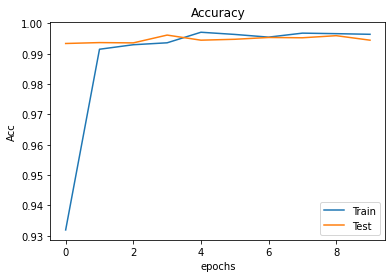

In [ ]:
plt.figure()
plt.plot(history7.history["accuracy"], label = "Train")
plt.plot(history7.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()


In [ ]:
pred = (model7.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.99      1.00      1.00      5858
        Real       1.00      0.99      0.99      5367

    accuracy                           1.00     11225
   macro avg       1.00      0.99      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Text(42.0, 0.5, 'Actual')

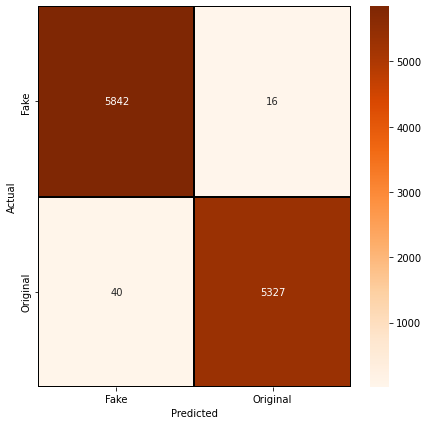

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
drive.mount('/content/drive')

path = "/content/drive/MyDrive/True.csv"
df2_RealData = pd.read_csv(path)

path = "/content/drive/MyDrive/Fake.csv"
df2_FakeData = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df2_RealData['label'] = 1
df2_FakeData['label'] = 0

In [ ]:
df2 = pd.concat([df2_RealData,df2_FakeData], ignore_index=True, sort=False)

In [ ]:
del df2['subject']
del df2['date']

In [ ]:
df2.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [ ]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
df2['text']=df2['text'].apply(cleaning)
df2['title']=df2['title'].apply(cleaning)

In [ ]:
#df2.to_csv('cleanData2channelf.csv', index=False)
drive.mount('/content/drive')

path = "/content/drive/MyDrive/cleanData2channelf.csv"
data2channel = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


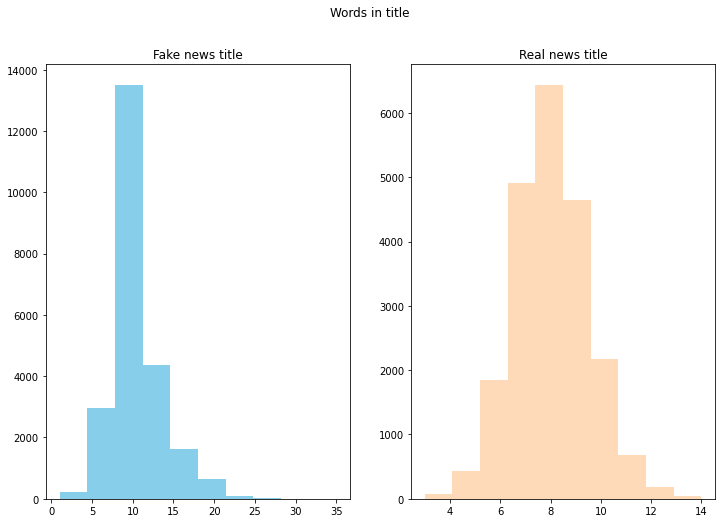

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data2channel[data2channel['label']==0]['title'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news title')
text_len=data2channel[data2channel['label']==1]['title'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news title')
fig.suptitle('Words in title')
plt.show()

In [ ]:
maxlen_title = 20

In [ ]:

data2channel.text=data2channel.text.astype(str)
data2channel.title=data2channel.title.astype(str)

In [ ]:
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(data2channel['title'], data2channel['label'], random_state=0)

In [ ]:
X_train_title_n,X_validation_title,y_train_title_n,y_validation_title = train_test_split(X_train_title,y_train_title,test_size = 0.3,random_state=0)

In [ ]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(data2channel['text'], data2channel['label'], random_state=0)

In [ ]:
X_train_text_n,X_validation_text,y_train_text_n,y_validation_text = train_test_split(X_train_text,y_train_text,test_size = 0.3,random_state=0)

In [ ]:
X_train_text_n

20592    washington reuters u navy said friday moving a...
9611     washington tokyo reuters barack obama become f...
29566    longstanding myth spread medium certainly oppo...
33395                                            via mrctv
18506    manchester england reuters besides diminished ...
                               ...                        
40239    dallas cowboy star wide receiver dez bryant to...
36101    taya kyle speaks obama regarding illogical str...
40557    knight socialism held event allowed student ba...
35519    american citizen eligible apply small business...
23062    donald trump went speak nra annual meeting tod...
Name: text, Length: 23571, dtype: object

In [ ]:
X_train_title_n

In [ ]:
tokenizer.fit_on_texts(X_train_title_n)
tokenized_train_title = tokenizer.texts_to_sequences(X_train_title_n)
X_train_title_n = sequence.pad_sequences(tokenized_train_title, maxlen=maxlen_title)
tokenized_test_title = tokenizer.texts_to_sequences(X_test_title)
X_test_title = sequence.pad_sequences(tokenized_test_title, maxlen=maxlen_title)

In [ ]:
tokenizer.fit_on_texts(X_train_text_n)
tokenized_train_text = tokenizer.texts_to_sequences(X_train_text_n)
X_train_text_n = sequence.pad_sequences(tokenized_train_text, maxlen=maxlen)
tokenized_test_text = tokenizer.texts_to_sequences(X_test_text)
X_test_text = sequence.pad_sequences(tokenized_test_text, maxlen=maxlen)

In [ ]:
tokenizer.fit_on_texts(X_validation_title)
tokenized_valid_title = tokenizer.texts_to_sequences(X_validation_title)
X_validation_title = sequence.pad_sequences(tokenized_valid_title, maxlen=maxlen_title)
tokenizer.fit_on_texts(X_validation_text)
tokenized_valid_text = tokenizer.texts_to_sequences(X_validation_text)
X_validation_text = sequence.pad_sequences(tokenized_valid_text, maxlen=maxlen)

In [ ]:
X_train_text

array([[ 0,  0,  0, ..., 26, 27, 14],
       [ 0,  0,  0, ..., 26, 27, 14],
       [ 0,  0,  0, ..., 26, 27, 14],
       ...,
       [ 0,  0,  0, ..., 26, 27, 14],
       [ 0,  0,  0, ..., 26, 27, 14],
       [ 0,  0,  0, ..., 26, 27, 14]], dtype=int32)

In [ ]:
data2channel

,title,text,label
0,u budget fight loom republican flip fiscal script,washington reuters head conservative republica...,1
1,u military accept transgender recruit monday p...,washington reuters transgender people allowed ...,1
2,senior u republican senator let mr mueller job,washington reuters special counsel investigati...,1
3,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...,1
4,trump want postal service charge much amazon s...,seattle washington reuters president donald tr...,1
...,...,...,...
44893,mcpain john mccain furious iran treated u sail...,st century wire say wire reported earlier week...,0
44894,justice yahoo settle e mail privacy class acti...,st century wire say familiar theme whenever di...,0
44895,sunnistan u allied safe zone plan take territo...,patrick henningsen st century wireremember oba...,0
44896,blow million al jazeera america finally call q...,st century wire say al jazeera america go hist...,0


In [ ]:
from keras.layers import Input , Flatten , Conv1D , MaxPool1D , concatenate

In [ ]:
input_title = Input(shape=(maxlen_title,))
input_text = Input(shape=(maxlen,))
embedding_title = Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen_title, trainable=False)(input_title)
Bilstm_title = keras.layers.Bidirectional(LSTM(40,dropout = 0.2,recurrent_dropout = 0.2))(embedding_title)

embedding_text = Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False)(input_text)
Bilstm_text = keras.layers.Bidirectional(LSTM(50,dropout = 0.2,recurrent_dropout = 0.2))(embedding_text)

concatenate_layer = concatenate([Bilstm_title,Bilstm_text])
Dense1 = keras.layers.Dense(60,activation='relu')(concatenate_layer)
Dropout1 = keras.layers.Dropout(0.3)(Dense1)
Dense2 = keras.layers.Dense(20,activation='relu')(Dropout1)
Dropout2 = keras.layers.Dropout(0.2)(Dense2)
Dense3 = keras.layers.Dense(5,activation='relu')(Dropout2)
Output = keras.layers.Dense(1,activation='sigmoid')(Dense3)
model_multichannel = keras.Model(inputs = [input_title,input_text],outputs=[Output])


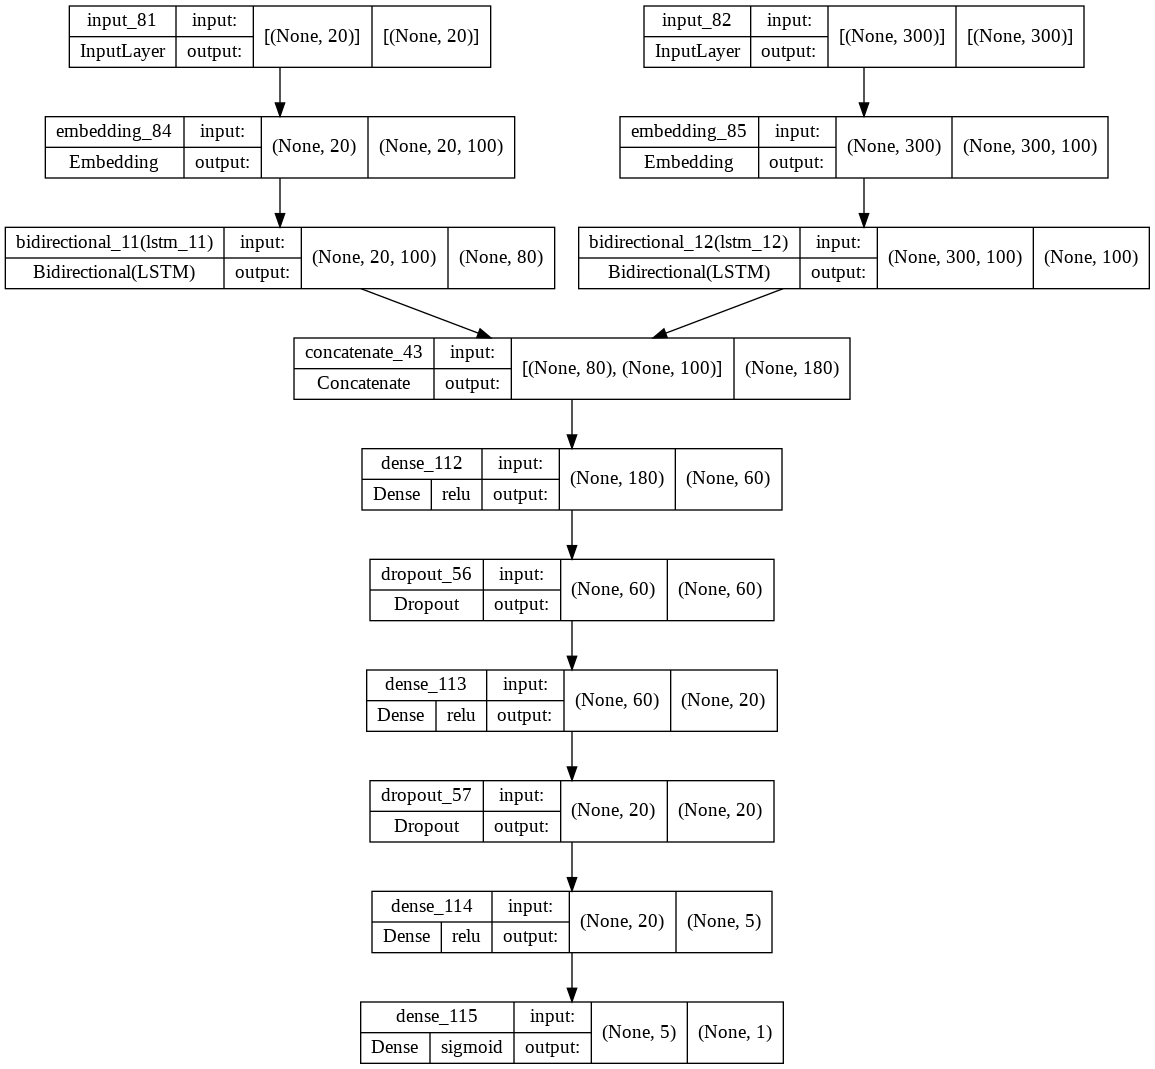

In [ ]:
tf.keras.utils.plot_model(
    model_multichannel,
    to_file='multiChannelBilstm.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [ ]:
model_multichannel.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model_multichannel.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_82 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_84 (Embedding)       (None, 20, 100)      1000000     ['input_81[0][0]']               
                                                                                                  
 embedding_85 (Embedding)       (None, 300, 100)     1000000     ['input_82[0][0]']               
                                                                                           

In [ ]:
history_model_multichannel = model_multichannel.fit((X_train_title_n,X_train_text_n), y_train_text_n, validation_data=((X_validation_title,X_validation_text),y_validation_text), epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 294s 3s/step - loss: 0.2617 - accuracy: 0.8883 - val_loss: 0.1635 - val_accuracy: 0.9402
Epoch 2/10
93/93 [==============================] - 283s 3s/step - loss: 0.0690 - accuracy: 0.9768 - val_loss: 0.0506 - val_accuracy: 0.9834
Epoch 3/10
93/93 [==============================] - 275s 3s/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 0.0384 - val_accuracy: 0.9869
Epoch 4/10
93/93 [==============================] - 277s 3s/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0467 - val_accuracy: 0.9859
Epoch 5/10
93/93 [==============================] - 283s 3s/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0587 - val_accuracy: 0.9815
Epoch 6/10
93/93 [==============================] - 282s 3s/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0534 - val_accuracy: 0.9857
Epoch 7/10
93/93 [==============================] - 275s 3s/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0406 - val_accuracy: 0.9880
Epoch 8/10
93

In [ ]:
#model_multichannel.save('BilstmwithGloveMultiChannel1.h5')
#drive.mount('/content/drive')

#path = "/content/drive/MyDrive/BilstmwithGloveMultiChannel.h5"
#model_multichannel = keras.models.load_model(path)

In [ ]:
print("Accuracy of the model on Training Data is - " , model_multichannel.evaluate((X_train_title_n,X_train_text_n), y_train_text_n)[1]*100 , "%")


737/737 [==============================] - 85s 115ms/step - loss: 0.0011 - accuracy: 0.9996
Accuracy of the model on Training Data is -  99.96181726455688 %


In [ ]:
print("Accuracy of the model on Testing Data is - " , model_multichannel.evaluate((X_test_title,X_test_text), y_test_text)[1]*100 , "%")

351/351 [==============================] - 40s 113ms/step - loss: 0.0178 - accuracy: 0.9958
Accuracy of the model on Testing Data is -  99.58128929138184 %


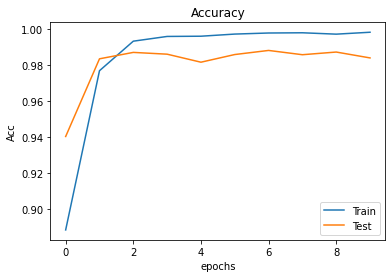

In [ ]:
plt.figure()
plt.plot(history_model_multichannel.history["accuracy"], label = "Train")
plt.plot(history_model_multichannel.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

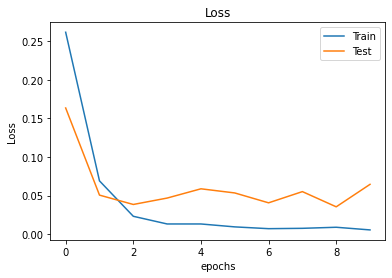

In [ ]:
plt.figure()
plt.plot(history_model_multichannel.history["loss"], label = "Train")
plt.plot(history_model_multichannel.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model_multichannel.predict((X_test_title,X_test_text)) > 0.5).astype("int32")
print(classification_report(y_test_text, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      5858
        Real       0.99      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Text(42.0, 0.5, 'Actual')

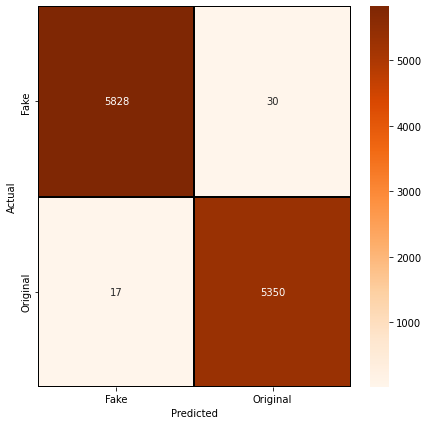

In [ ]:
cm = confusion_matrix(y_test_text,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
input_title = Input(shape=(maxlen_title,))
input_text = Input(shape=(maxlen,))
embedding_title = Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen_title, trainable=False)(input_title)
Bilstm_title = keras.layers.Bidirectional(LSTM(40,dropout = 0.3,recurrent_dropout = 0.2))(embedding_title)

embedding_text = Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False)(input_text)
Bilstm_text = keras.layers.Bidirectional(LSTM(50,dropout = 0.3,recurrent_dropout = 0.2))(embedding_text)

concatenate_layer = concatenate([Bilstm_title,Bilstm_text])
Dense1 = keras.layers.Dense(60,activation='relu')(concatenate_layer)
Dropout1 = keras.layers.Dropout(0.3)(Dense1)
Dense2 = keras.layers.Dense(20,activation='relu')(Dropout1)
Dropout2 = keras.layers.Dropout(0.3)(Dense2)
Dense3 = keras.layers.Dense(5,activation='relu')(Dropout2)
Output = keras.layers.Dense(1,activation='sigmoid')(Dense3)
model_multichannel2 = keras.Model(inputs = [input_title,input_text],outputs=[Output])


In [ ]:
model_multichannel2.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model_multichannel2.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_83 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_84 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_89 (Embedding)       (None, 20, 100)      1000000     ['input_83[0][0]']               
                                                                                                  
 embedding_90 (Embedding)       (None, 300, 100)     1000000     ['input_84[0][0]']               
                                                                                           

In [ ]:
history_model_multichannel2 = model_multichannel2.fit((X_train_title_n,X_train_text_n), y_train_text_n, validation_data=((X_validation_title,X_validation_text),y_validation_text), epochs=15, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/15
93/93 [==============================] - 315s 3s/step - loss: 0.3495 - accuracy: 0.8472 - val_loss: 0.1392 - val_accuracy: 0.9461
Epoch 2/15
93/93 [==============================] - 285s 3s/step - loss: 0.0531 - accuracy: 0.9844 - val_loss: 0.0784 - val_accuracy: 0.9745
Epoch 3/15
93/93 [==============================] - 275s 3s/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.0747 - val_accuracy: 0.9781
Epoch 4/15
93/93 [==============================] - 268s 3s/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0743 - val_accuracy: 0.9791
Epoch 5/15
93/93 [==============================] - 272s 3s/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.0890 - val_accuracy: 0.9787
Epoch 6/15
93/93 [==============================] - 275s 3s/step - loss: 0.0184 - accuracy: 0.9954 - val_loss: 0.1365 - val_accuracy: 0.9696
Epoch 7/15
93/93 [==============================] - 272s 3s/step - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.0932 - val_accuracy: 0.9758
Epoch 8/15
93

In [ ]:
#history_model_multichannel_more_epoch = model_multichannel.fit((X_train_title_n,X_train_text_n), y_train_text_n, validation_data=((X_validation_title,X_validation_text),y_validation_text), epochs=15, batch_size=batch_size, shuffle=True, verbose = 1)

In [ ]:
model_conv1D_withBilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, output_dim=embed_size,weights = [embedding_matrix], input_length=maxlen, trainable=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_conv1D_withBilstm.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss="binary_crossentropy", metrics=['accuracy'])
model_conv1D_withBilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, 300, 100)          1000000   
                                                                 
 dropout_60 (Dropout)        (None, 300, 100)          0         
                                                                 
 conv1d_135 (Conv1D)         (None, 296, 64)           32064     
                                                                 
 max_pooling1d_131 (MaxPooli  (None, 74, 64)           0         
 ng1D)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_118 (Dense)           (None, 1)                

In [ ]:
history_model_conv1D_withBilstm = model_conv1D_withBilstm.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 112s 936ms/step - loss: 0.2626 - accuracy: 0.8934 - val_loss: 0.1181 - val_accuracy: 0.9612
Epoch 2/10
93/93 [==============================] - 85s 920ms/step - loss: 0.1163 - accuracy: 0.9569 - val_loss: 0.0510 - val_accuracy: 0.9830
Epoch 3/10
93/93 [==============================] - 84s 906ms/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.0270 - val_accuracy: 0.9906
Epoch 4/10
93/93 [==============================] - 87s 933ms/step - loss: 0.0335 - accuracy: 0.9885 - val_loss: 0.0301 - val_accuracy: 0.9899
Epoch 5/10
93/93 [==============================] - 82s 877ms/step - loss: 0.0310 - accuracy: 0.9895 - val_loss: 0.0265 - val_accuracy: 0.9914
Epoch 6/10
93/93 [==============================] - 84s 908ms/step - loss: 0.0256 - accuracy: 0.9914 - val_loss: 0.0256 - val_accuracy: 0.9903
Epoch 7/10
93/93 [==============================] - 81s 871ms/step - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0191 - val_accuracy: 0.994

In [ ]:
print("Accuracy of the model on Training Data is - " , model_conv1D_withBilstm.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model_conv1D_withBilstm.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 57s 54ms/step - loss: 0.0096 - accuracy: 0.9973
Accuracy of the model on Training Data is -  99.72975254058838 %
351/351 [==============================] - 13s 36ms/step - loss: 0.0193 - accuracy: 0.9945
Accuracy of the model on Testing Data is -  99.44766163825989 %


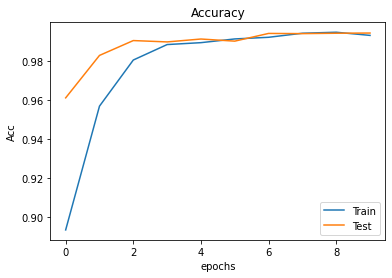

In [ ]:
plt.figure()
plt.plot(history_model_conv1D_withBilstm.history["accuracy"], label = "Train")
plt.plot(history_model_conv1D_withBilstm.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

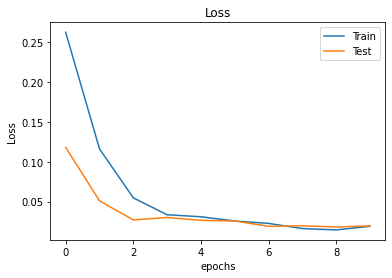

In [ ]:
plt.figure()
plt.plot(history_model_conv1D_withBilstm.history["loss"], label = "Train")
plt.plot(history_model_conv1D_withBilstm.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
pred = (model_conv1D_withBilstm.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      5858
        Real       0.99      1.00      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



Text(42.0, 0.5, 'Actual')

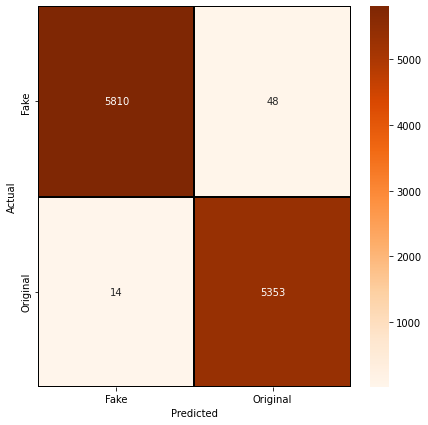

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
!pip install tensorflow-text
import tensorflow_text as text

In [ ]:
!pip install --quiet transformers
from transformers import TFBertModel, BertTokenizer
import tensorflow_hub as hub

     |████████████████████████████████| 4.7 MB 25.8 MB/s 
     |████████████████████████████████| 120 kB 71.9 MB/s 
     |████████████████████████████████| 6.6 MB 61.7 MB/s 


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# Step 1: tokenize batches of text inputs.
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 2 (optional): modify tokenized inputs.
pass

# Step 3: pack input sequences for the Transformer encoder.
seq_length = 300
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)

In [ ]:
encoder_inputs

{'input_mask': <KerasTensor: shape=(None, 300) dtype=int32 (created by layer 'keras_layer_28')>,
 'input_word_ids': <KerasTensor: shape=(None, 300) dtype=int32 (created by layer 'keras_layer_28')>,
 'input_type_ids': <KerasTensor: shape=(None, 300) dtype=int32 (created by layer 'keras_layer_28')>}

In [ ]:
#text_input = tf.keras.layers.Input(shape=(), dtype=tf.string,name='text')
#preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(encoder_inputs)

In [ ]:
l = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])

l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=text_inputs, outputs = [l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_3 (KerasLayer)     {'input_type_ids':   0           ['keras_layer_2[0][0]']          
                                (None, 300),                                                      
                                 'input_word_ids':                                                
                                (None, 300),                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
history_model_BERT = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=128)

Epoch 1/10
185/185 [==============================] - 909s 5s/step - loss: 0.4105 - accuracy: 0.8173 - val_loss: 0.3220 - val_accuracy: 0.8727
Epoch 2/10
185/185 [==============================] - 903s 5s/step - loss: 0.2980 - accuracy: 0.8754 - val_loss: 0.2708 - val_accuracy: 0.8851
Epoch 3/10
185/185 [==============================] - 903s 5s/step - loss: 0.2795 - accuracy: 0.8839 - val_loss: 0.2649 - val_accuracy: 0.8944
Epoch 4/10
185/185 [==============================] - 903s 5s/step - loss: 0.2723 - accuracy: 0.8876 - val_loss: 0.2658 - val_accuracy: 0.8938
Epoch 5/10
185/185 [==============================] - 904s 5s/step - loss: 0.2657 - accuracy: 0.8927 - val_loss: 0.2644 - val_accuracy: 0.8865
Epoch 6/10
185/185 [==============================] - 901s 5s/step - loss: 0.2599 - accuracy: 0.8932 - val_loss: 0.2806 - val_accuracy: 0.8776
Epoch 7/10
185/185 [==============================] - 902s 5s/step - loss: 0.2586 - accuracy: 0.8916 - val_loss: 0.2356 - val_accuracy: 0.9074

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4")

In [ ]:
preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# Step 1: tokenize batches of text inputs.
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 2 (optional): modify tokenized inputs.
pass

# Step 3: pack input sequences for the Transformer encoder.
seq_length = 200
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)

In [ ]:
outputs = bert_encoder(encoder_inputs)

In [ ]:
l = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])

l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
model2 = tf.keras.Model(inputs=text_inputs, outputs = [l])
model2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 keras_layer_35 (KerasLayer)    (None, None, None)   0           ['input_11[0][0]']               
                                                                                                  
 keras_layer_36 (KerasLayer)    {'input_word_ids':   0           ['keras_layer_35[0][0]']         
                                (None, 200),                                                      
                                 'input_mask': (Non                                               
                                e, 200),                                                   

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model2.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
history_model_BERT2 = model2.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=50)

Epoch 1/5
472/472 [==============================] - 1619s 3s/step - loss: 0.6254 - accuracy: 0.6815 - val_loss: 0.4619 - val_accuracy: 0.7937
Epoch 2/5
472/472 [==============================] - 1602s 3s/step - loss: 0.5340 - accuracy: 0.7429 - val_loss: 0.4636 - val_accuracy: 0.7808
Epoch 3/5
472/472 [==============================] - 1602s 3s/step - loss: 0.5359 - accuracy: 0.7486 - val_loss: 0.6823 - val_accuracy: 0.6379
Epoch 4/5
472/472 [==============================] - 1602s 3s/step - loss: 0.5277 - accuracy: 0.7539 - val_loss: 0.5173 - val_accuracy: 0.7604
Epoch 5/5
472/472 [==============================] - 1624s 3s/step - loss: 0.5738 - accuracy: 0.7375 - val_loss: 0.3974 - val_accuracy: 0.8228
